In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

/home/pkubik/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
matplotlib.rc('figure', figsize=(10., 10.))

In [21]:
from collections import namedtuple
Dataset = namedtuple('Dataset', 'image, label')
train_tuple, test_tuple = tf.keras.datasets.cifar10.load_data()
train_split = Dataset(*train_tuple)
test_split = Dataset(*test_tuple)

subset = train_split.image[train_split.label[:, 0] == 8, :]

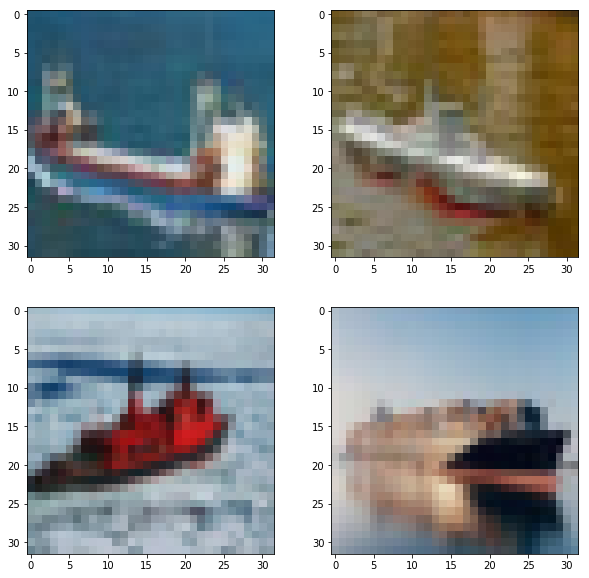

In [22]:
example_indices = np.random.choice(len(subset), 4)
for i, idx in enumerate(example_indices):
    plt.subplot(2, 2, i + 1)
    plt.imshow(subset[idx, :, :])
plt.show()

In [23]:
def clip(x, eps=10e-16):
    return tf.clip_by_value(x, eps, 1 - eps)


class VLB:
    def __init__(self, x, x_decoded_mean, t_mean, t_log_var):
        """Variational Lower Bound for Gaussian `p(x | t)`.

        Inputs:
            x: (batch_size x width x height x num_channels)
                tensor of the input images
            x_decoded_mean: (batch_size x width x height x num_channels)
                mean of the estimated distribution `p(x | t)`, real numbers from 0 to 1
            t_mean: (batch_size x latent_dim)
                mean vector of the (normal) distribution `q(t | x)`
            t_log_var: (batch_size x latent_dim)
                logarithm of the variance vector of the (normal) distribution `q(t | x)`

        Returns:
            A tf.Tensor with one element (averaged across the batch), VLB
        """
        batch_size = tf.shape(x)[0]

        # Reconstruction loss, log p(x | t)
        flat_x = tf.reshape(x, [batch_size, -1])
        flat_x_mean = tf.reshape(x_decoded_mean, [batch_size, -1])
        x_mse = tf.reduce_sum(tf.square(flat_x - flat_x_mean), -1)
        rec_loss = x_mse / 2 * 4  # Assuming sigma of x equals 1/2
        self.reconstruction_loss = tf.reduce_mean(rec_loss)

        # Regularization loss, KL(q || p)
        t_dist = tf.distributions.Normal(t_mean, tf.exp(t_log_var / 2))
        t_prior = tf.distributions.Normal(tf.zeros_like(t_mean), tf.ones_like(t_mean))
        kl_t = tf.reduce_sum(tf.distributions.kl_divergence(t_dist, t_prior), -1)
        self.regularization_loss = tf.reduce_mean(kl_t)

        self.total_loss = self.reconstruction_loss + self.regularization_loss

In [65]:
class Encoder:
    def __init__(self, latent_dim):
        self.conv_layers = [
            tf.layers.Conv2D(5, 3, activation=tf.nn.relu),
            tf.layers.Conv2D(10, 4, activation=tf.nn.relu),
            tf.layers.Conv2D(20, 3, 2, activation=tf.nn.relu),
            tf.layers.Conv2D(50, 3, activation=tf.nn.relu),
            tf.layers.Conv2D(100, 3, 2, activation=tf.nn.relu),
            tf.layers.Conv2D(200, 3, activation=tf.nn.relu)
        ]
        self.mid_layer = tf.layers.Dense(500, activation=tf.tanh)
        self.mean_layer = tf.layers.Dense(latent_dim)
        self.log_var_layer = tf.layers.Dense(latent_dim)
    
    def __call__(self, x) -> tf.distributions.Normal:
        """
        Generate parameters for the estimated `q(t | x)` distribution.
        """
        h = x
        for conv in self.conv_layers:
            h = conv(h)
        
        final_h = self.mid_layer(tf.layers.flatten(h))
        
        mean = self.mean_layer(final_h)
        std = tf.exp(self.log_var_layer(final_h) / 2)
        return tf.distributions.Normal(mean, std)

In [96]:
class Decoder:
    def __init__(self, image_shape: list):      
        self.init_layer = tf.layers.Dense(900, activation=tf.nn.relu)
        
        self.conv_layers = [
            tf.layers.Conv2DTranspose(100, 3, activation=tf.nn.relu),
            tf.layers.Conv2DTranspose(100, 3, 2, activation=tf.nn.relu),
            tf.layers.Conv2DTranspose(50, 3, activation=tf.nn.relu),
            tf.layers.Conv2DTranspose(50, 3, 2, activation=tf.nn.relu),
            tf.layers.Conv2DTranspose(10, 4, activation=tf.nn.relu),
            #tf.layers.Conv2D(10, 3, padding='SAME', activation=tf.tanh),
            tf.layers.Conv2DTranspose(10, 3)
        ]
        
    def __call__(self, t):
        """
        Output the image distribution `p(x | t)` given the latent code.
        """
        batch_size = tf.shape(t)[0]
        init_h = self.init_layer(t)
        
        h = tf.reshape(init_h, [-1, 3, 3, 100])
        for conv in self.conv_layers:
            h = conv(h)
        
        h = tf.concat([tf.layers.conv2d(h, 20, 1, activation=tf.tanh),
                       tf.layers.conv2d(h, 10, 3, activation=tf.tanh, padding='SAME'),
                       tf.layers.conv2d(h, 10, 5, activation=tf.tanh, padding='SAME')], -1)
        h = tf.layers.conv2d(h, 3, 1)
        
        return tf.sigmoid(h)

In [97]:
VAETrainSpec = namedtuple('VAETrainSpec', 'train_op, vlb, loss')


class VAE:
    latent_dim = 20
    
    def __init__(self, x):
        self.image_shape = list(x.shape[1:])
        self.x = tf.identity(x, name='x')
        self.encoder = Encoder(self.latent_dim)
        self.decoder = Decoder(self.image_shape)
        
        # Compute `q(t | x)` parameters, feed prior p(t) to hallucinate
        self.t_dist = self.encoder(self.x)
        self.t_scale_mean = tf.reduce_mean(self.t_dist.scale)
        
        # Sample `t`
        self.t = tf.identity(self.t_dist.sample(), name='t')
        
        # Generate mean output distribution `p(x | t)`
        self.x_mean = tf.identity(self.decoder(self.t), name='x_mean')

    def create_train_spec(self):
        vlb = VLB(self.x, self.x_mean, self.t_dist.loc, tf.log(self.t_dist.scale) * 2)
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(vlb.total_loss, tf.train.get_global_step())
        
        return VAETrainSpec(train_op, vlb, vlb.total_loss)

In [98]:
from IPython.display import clear_output


def norm_data(data):
    return data.astype(np.float32) / 255


class Model:
    batch_size = 64
    
    def __init__(self):
        self.gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
        self.config_proto = tf.ConfigProto(gpu_options=self.gpu_options)
        self.last_session = None
        
    def train(self, data: Dataset):
        data = norm_data(data)
        
        graph = tf.Graph()
        with graph.as_default():
            dataset = tf.data.Dataset.from_tensor_slices(data)
            dataset = dataset.repeat()
            dataset = dataset.shuffle(4)
            dataset = dataset.batch(self.batch_size)
            dataset = dataset.prefetch(4)

            batch_iterator = dataset.make_one_shot_iterator().get_next()
            
            vae = VAE(batch_iterator)
            vae_train = vae.create_train_spec()

        sess = tf.Session(graph=graph, config=self.config_proto)
        self.last_session = sess
        with graph.as_default(), sess.as_default():
            sess.run([tf.global_variables_initializer(),
                      tf.local_variables_initializer()])

            progbar = tf.keras.utils.Progbar(1000000)
            for i in range(1000000):
                _, loss, t, t_scale_mean, rec_loss, reg_loss, x_batch, x_mean_batch = sess.run(
                    [vae_train.train_op,
                     vae_train.vlb.total_loss,
                     vae.t,
                     vae.t_scale_mean,
                     vae_train.vlb.reconstruction_loss,
                     vae_train.vlb.regularization_loss,
                     vae.x,
                     vae.x_mean])

                if i % 1000 == 0:
                    image, test_t = sess.run([vae.x_mean, vae.t], feed_dict={
                        vae.x: [data[1], subset[-1]],
                        vae.t_dist.scale: np.zeros([1, vae.latent_dim])
                    })
                    sampled_t, sampled_image = sess.run([vae.t, vae.x_mean], feed_dict={
                        vae.t_dist.loc: np.zeros([self.batch_size, vae.latent_dim]),
                        vae.t_dist.scale: np.ones([self.batch_size, vae.latent_dim])
                    })
                    
                    clear_output(wait=True)
                    fig = plt.figure(figsize=(12, 16))
                    grid = plt.GridSpec(3, 2)
                    
                    plt.subplot(grid[0, 0], title='Train example')
                    plt.imshow(data[1])
                    
                    plt.subplot(grid[0, 1], title='Train reconstruction')
                    plt.imshow(np.clip(image[0], 0., 1.))
                    
                    plt.subplot(grid[1, 0], title='Test example')
                    plt.imshow(subset[-1])
                    
                    plt.subplot(grid[1, 1], title='Test reconstruction')
                    plt.imshow(np.clip(image[1], 0., 1.))
                    
                    plt.subplot(grid[2, 0], title='t values (first 2 dims)')
                    x_values = np.reshape(x_batch, [-1])
                    plt.scatter(t[:, 0], t[:, 1])
                    plt.scatter(test_t[0, 0], test_t[0, 1], s=64)
                    plt.scatter(test_t[1, 0], test_t[1, 1], s=64, marker='x')
                    plt.scatter(sampled_t[0, 0], sampled_t[0, 1], s=64, marker='^')
                    
                    plt.subplot(grid[2, 1], title='Sampled image')
                    plt.imshow(np.clip(sampled_image[0], 0., 1.))
                    
                    plt.show()

                progbar.update(i, [
                    ('rec loss', rec_loss),
                    ('reg loss', reg_loss),
                    ('t scale', t_scale_mean)])

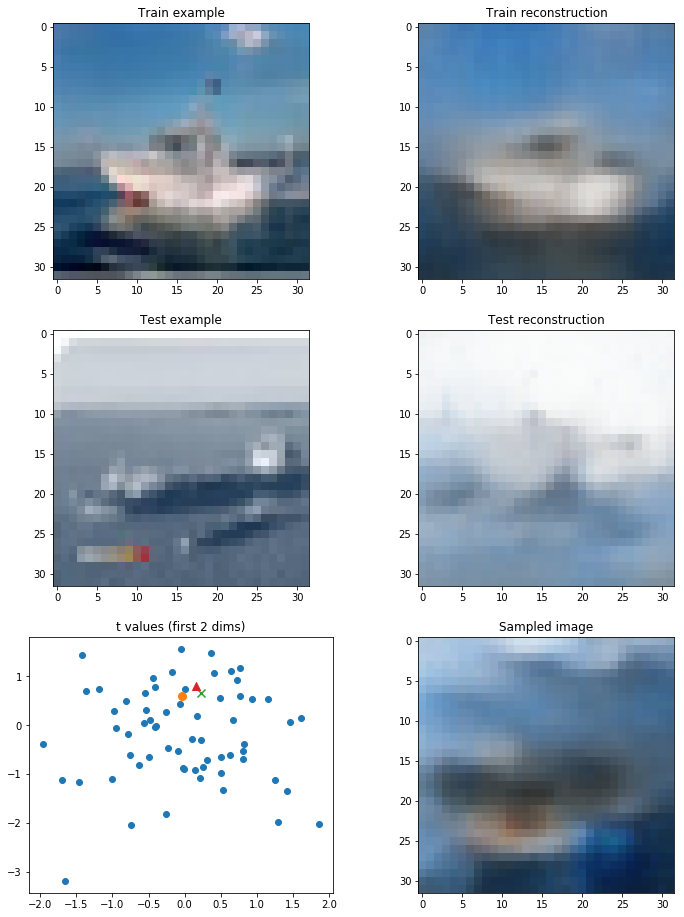

 283248/1000000 [=======>......................] - ETA: 3:22:39 - rec loss: 49.6180 - reg loss: 27.6471 - t scale: 0.3802

In [ ]:
model = Model()
model.train(subset[:-2])

In [ ]:
plt.imshow(model.last_session.run('x_mean:0', feed_dict={'t:0': np.ones([1, 2])})[0])

In [71]:
4000 / 4400

0.9090909090909091